# **Answer 3:** Regression with linear neurons

In [29]:
%matplotlib inline
from __future__ import print_function
from itertools import count

import torch
import torch.nn as nn
import torch.autograd
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from timeit import default_timer as timer
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

POLY_DEGREE = 4
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5

print(W_target)
print(b_target)

data = pd.read_csv("./qn2_data.csv", delimiter = ',', names = ['fertilizers', 'insecticides', 'production'])
train_x = data.drop('production', axis=1).to_numpy()
train_y = data['production'].to_numpy()
train_y = train_y.reshape((train_y.shape[0],1))

train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()

tensor([[ -7.7073],
        [  4.2833],
        [ -2.1518],
        [-10.2760]])
tensor([3.2382])


In [30]:
def make_features(x):
    x = x.unsqueeze(1)
    return torch.cat([x**i for i in range(1, POLY_DEGREE+1)], 1)

In [31]:
def f(x):
    return x.mm(W_target) + b_target[0]

In [32]:
def poly_desc(W, b):
    result = 'y = '
    for i ,w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - 1)
    result += '{:+.2f}'.format(b[0])
    return result

In [33]:
def get_batch(batch_size = 32):
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    return Variable(x), Variable(y)

In [133]:
def random_dataset():
    #print(W_target.size(0))
    fc = torch.nn.Linear(W_target.size(0), 1)
    lr_rate = [0.01,0.025,0.05,0.1,0.2]
    batch_idx_arr = []
    for learning_rate in lr_rate:
        optimizer= torch.optim.SGD(fc.parameters(), lr = learning_rate)

        for batch_idx in count(1):
            batch_x, batch_y = get_batch()
            optimizer.zero_grad()

        #     Forward
            output = F.smooth_l1_loss(fc(batch_x), batch_y)
            loss = output.data

        #     Backward
            output.backward()

            optimizer.step()

        #     Stop Criterion
            if(loss < 1e-3):
                break
        print('Learning Rate-> {:+.3f}'.format(learning_rate))
        print('Loss: {:+.6f} after {} batches'.format(loss, batch_idx))
        batch_idx_arr.append(batch_idx)

    return lr_rate,batch_idx_arr

        

# Part a) for SGD - Modifing the learning rate and observing its effect

In [ ]:
lr_rate,batch_idx_arr = random_dataset()

fig2 = plt.figure()
plt.plot(lr_rate,batch_idx_arr, 'go', linestyle='-')
fig2.suptitle('learning rate vs #batches', fontsize=20)
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('#batches', fontsize=12)

plt.show()


Learning Rate-> +0.010,       Loss: +0.000956 after 3241 batches

Learning Rate-> +0.025,       Loss: +0.000835 after 1 batches

Learning Rate-> +0.050,       Loss: +0.000241 after 48 batches

Learning Rate-> +0.100,       Loss: +0.000483 after 1 batches

Learning Rate-> +0.200,       Loss: +0.000167 after 1 batches

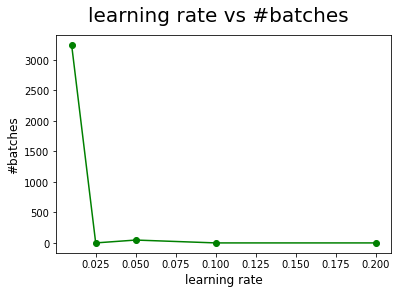

In [94]:
def toy_dataset():
    fc = torch.nn.Linear(train_x.size(1), 1)
    
    learning_rate = 0.001
    
    optimizer= torch.optim.SGD(fc.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)

    for epoch in count(1):
        #     Get data
        batch_x, batch_y = Variable(train_x), Variable(train_y)
        #     Reset Gradients
        optimizer.zero_grad()

        #     Forward pass
        output = F.smooth_l1_loss(fc(batch_x), batch_y)
        loss = output.data

        #     Backward Pass
        output.backward()

        optimizer.step()

        #     Stop Criterion
        if(loss < 0.59):
            break
    print('Learning Rate-> {:+.3f}'.format(learning_rate))
    print('Loss: {:+.6f} after {} batches'.format(loss, epoch))

    return learning_rate, epoch, fc.weight.data.view(-1), fc.bias.data

# Part b) SGD with toy dataset

In [ ]:
lr, epoch, weight, bias = toy_dataset()

test = torch.Tensor([[6,4],[10,5],[14,8]])
ans = test.mm(weight.view(-1,1)) + bias

print ("\nWeights = " , weight)
print ("bias = " , bias)

Learing rate -> 0.001, Nesterov = True, momentum = 0.9
Loss -> +0.589992 after 20599 batches

Weights = [0.7674, 0.9943]

bias = [31.3090]

Answer for test data ([[6,4],[10,5],[14,8]]) = [39.8905, 43.9544, 50.0068] = **[40, 44, 50]**

In [139]:
def least_square():
    bias = np.ones((train_x.shape[0],train_x.shape[1]+1))

    bias[:, 1:] = train_x
    X = torch.from_numpy(bias).float()
    y = train_y

    
    theta = torch.mm(torch.mm((torch.inverse(torch.mm(torch.t(X),X))), torch.t(X)), y)
    
    weight_closed = theta[1:3, :]
    bias_closed = theta[0, :]

    ans = test.mm(weight_closed) + bias_closed

    return weight_closed, bias_closed, ans


# Part c) least squares solution

In [142]:
weights_ls, bias_ls, prediction = least_square()

print ("\nWeights = " , weights_ls)
print ("bias = " , bias_ls)
print ("Prediction = " , prediction)


Weights =  tensor([[0.6501],
        [1.1099]])
bias =  tensor([31.9806])
Prediction =  tensor([[40.3205],
        [44.0306],
        [49.9605]])


Weights = [0.6500, 1.1099]

bias = [31.9806]

Answer = [ 40.3203, 44.0302, 49.9599] = **[40, 44, 50]**